# Classifiez automatiquement des biens de consommation

## Résumé du projet
"Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description

L'objectif principal de ce projet est d'etudier la faisabilité d'un moteur de classification des articles en différentes catégories des dponnees de l'entreprise Place de marché.

Cela permetra de  rendre l’expérience utilisateur des vendeurs et des acheteurs  la plus fluide possible. En plus, dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche 


## Chargement des bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
import random as rn
import cv2
import time
import string
import sklearn.metrics as metrics
import tensorflow as tf

from zipfile import ZipFile
from os import listdir
from pathlib import Path
from functools import reduce
from tqdm import tqdm
from random import shuffle  
from PIL import Image
from numpy import genfromtxt
from wordcloud import WordCloud, STOPWORDS

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import intercluster_distance
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn import decomposition, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix
from sklearn.metrics import precision_score, accuracy_score


pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
rstate=10
seed = 10

## Données

In [3]:
dir_data = Path('../../DATA/P6') 
dir_fig  = Path('../../FIGURE/P6')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../../DATA/P6/Flipkart')  
img_path = Path(str(CHECK_FOLDER) + str('/Images/'))
desc_data=str(dir_data)+'/df_clean.csv'

data_merged=pd.read_csv(desc_data)

### Traitement d'image

In [4]:
orb_description = []
sift_description = []
imgs=[]
imgs = []
labels = []
categ=[]
IMAGE_SIZE=(224,224)

# Initiate SIFT 
sift= cv2.SIFT_create()

# Boucle sur les images
for image in data_merged['image']:
    # Chargement des images 
    img = cv2.imread(str(img_path)+'/'+image)

    # Convering to Gray
    img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # convert all picture to the same size
    img = cv2.resize(img, IMAGE_SIZE) 

    # Amélioration contraste
    img = cv2.equalizeHist(img) 

    # Débruitage
    img = cv2.fastNlMeansDenoising(img)

    # filtre gausien
    img = cv2.GaussianBlur(img, (5, 5), 1)

    # find the keypoints and descriptors with sift
    Keypoint_sift , Descripteur_sift = sift.detectAndCompute(img,None)
    sift_description.append(Descripteur_sift)
        
    indx=data_merged[(data_merged['image'] == image)].index.values
    lab = data_merged['L_Categories_text'][indx]
    Cat = data_merged['Categories_text'][indx]
                
    # Append the image 
    imgs.append(img)
    labels.append(lab)
    categ.append(Cat)

imgs = np.array(imgs, dtype = 'float32') 
labels = np.array(labels, dtype = 'int32') 
categ  = np.array(categ)
      
sift_description_by_img = np.asarray(sift_description)
sift_description_all    = np.concatenate(sift_description_by_img, axis=0)
sift_description_pd     = pd.DataFrame(sift_description_all)
    

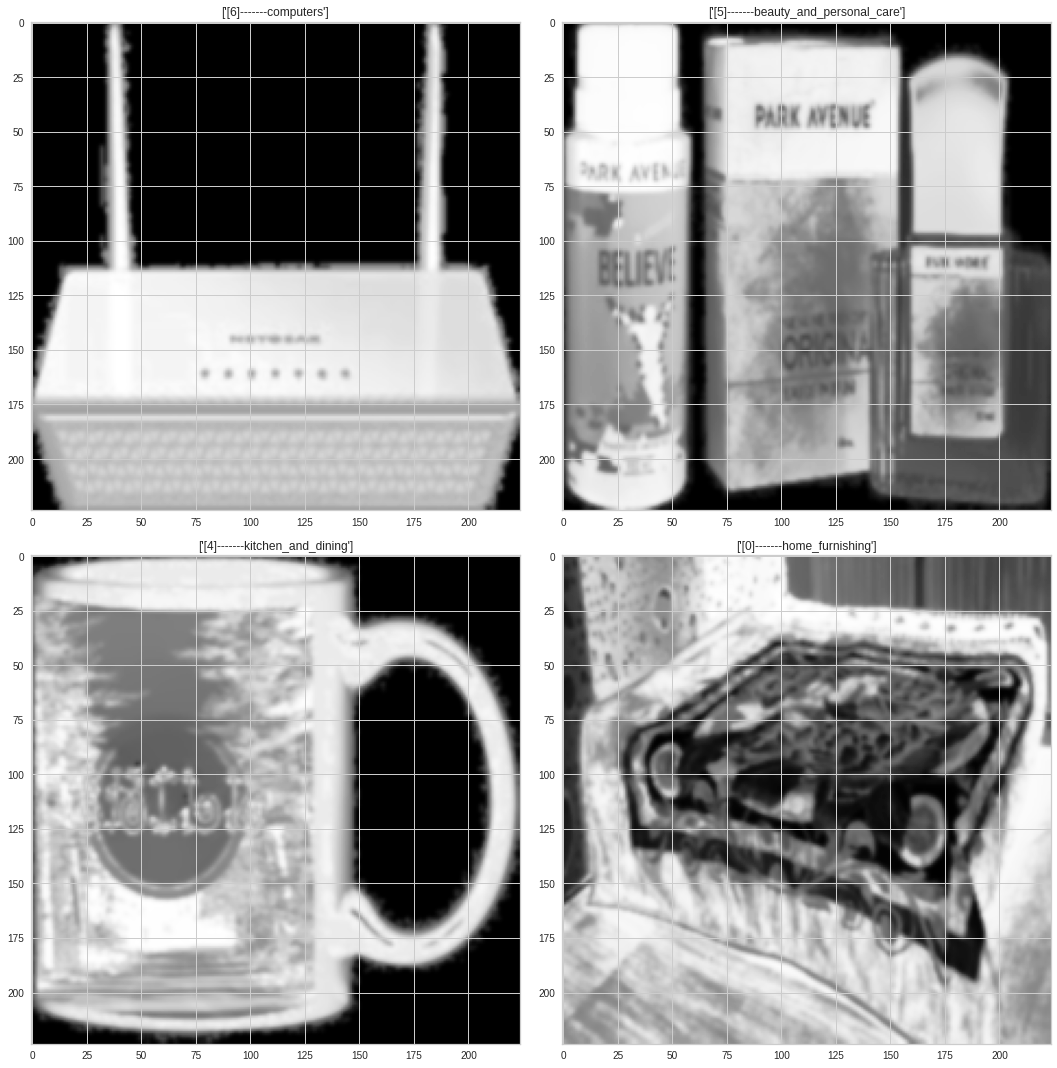

In [5]:

fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (2):
        l=rn.randint(0,len(labels))
        ax[i,j].imshow(imgs[l])
        ax[i,j].set_title(str(labels[l])+'-------'+categ[l])
        
plt.tight_layout()

        
plt.savefig('exemple_image.jpeg',format='jpeg',dpi=100,bbox_inches='tight')

!cp "exemple_image.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "exemple_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


## Modélisation

### Classification non supervisée 

In [6]:
Idetector= {
     "sift": 'kmeans_sift'
    } 
Duration_detector={
     "sift": 'duration_sift'
    } 

Data_detector={
     "sift": sift_description_all
    }
for k in  Idetector:
    print(k)
    nclusters = int(round(np.sqrt(len(Data_detector[k])),0))
    temps1=time.time()
    # Clustering
    Idetector[k] = cluster.MiniBatchKMeans(nclusters, init_size=3*nclusters, random_state=rstate)
    Idetector[k].fit(Data_detector[k])
    Duration_detector[k]=time.time()-temps1

    print('Duration',k,':',Duration_detector[k])

sift
Duration sift : 21.134982347488403


#### Création des features des images

In [7]:
# Creation of histograms (features)

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
def hist_build(description_all,model):
    hist_vectors=[]
    for i, image_desc in enumerate(description_all) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(model, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)
    
    return im_features

In [8]:
Data_detector_img={
     "sift": sift_description_by_img
    }
im_feature_keap={
            "sift": 'im_feature_sift'}

for k in  Idetector:
    data_kept=Data_detector_img[k]
    model_kept=Idetector[k]
    im_feature=im_feature_keap[k]
    print('model kept is:',k)
        
temps1=time.time()
im_features=hist_build(data_kept,model_kept)
duration1=time.time()-temps1

print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


model kept is: sift
0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.03 secondes


#### Réductions de dimension

##### Réduction de dimension PCA

In [9]:
dss=16
def display_scree_plot(pca,pc_list,ax,num_pc):
    scree = pca.explained_variance_ratio_*100
    ax.bar(pc_list, scree, alpha=0.5, align='center', label='individual explained variance')
    ax.step(pc_list,  scree.cumsum(),c="red",marker='o',where= 'mid', label='cumulative explained variance')
    plt.xticks(rotation =90) 
    ax.set_xticks(range(0,num_pc,25))
    ax.set_xticklabels( range(0,num_pc,25),size=dss-2)
    ax.set_xlabel("PCs",size=dss-2)
    ax.set_ylabel("Ratio de la variance expliqué",size=dss-2)
    ax.legend(loc = 'best')
    plt.xticks(fontsize=dss-2)
    plt.yticks(fontsize=dss-2)
    ax.legend(loc = 'best')
    plt.xticks(fontsize=dss-2)
    plt.yticks(fontsize=dss-2)
    
def pca_dim_reduction(df,var_explaned,figure_name,figure_name1 ):
    pcamodel=decomposition.PCA(var_explaned)
    pcamodel.fit(df)
    explained_var=pcamodel.explained_variance_ratio_
    explained=pcamodel.explained_variance_ratio_.cumsum()
    loadings = pcamodel.components_
    num_pc = len(pcamodel.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))]  
#
    df_dim_red=pcamodel.transform(df)
    df_dim_red = pd.DataFrame(data=df_dim_red, columns=pc_list)

    fig, ax = plt.subplots(figsize=(25,8))
 
    display_scree_plot(pcamodel,pc_list,ax,num_pc)
    
    
    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
    plt.savefig(figure_name1,format='jpeg',dpi=100,bbox_inches='tight')
    
    return df_dim_red,pcamodel

[0.95030029 0.95071306 0.95112522 0.95153534 0.95194249 0.95234791
 0.95275191 0.95315043 0.95354829 0.95394513 0.95433933 0.95472849
 0.95511709 0.95550226 0.95588538 0.95626534 0.95664485 0.95702229
 0.95739632 0.95776667 0.95813532 0.95850108 0.958866   0.95922637
 0.95958382 0.9599387  0.96029152 0.96064092 0.96098695 0.96133227
 0.96167504 0.96201704 0.9623552  0.96269196 0.96302434 0.96335659
 0.96368659 0.96401647 0.96434277 0.964668   0.96499012 0.96531124
 0.96563077 0.96594812 0.96626233 0.96657587 0.96688571 0.96719343
 0.96749917 0.96780239 0.96810369 0.96840414 0.96870271 0.9689995
 0.96929322 0.9695851  0.96987536 0.97016319 0.97045023 0.97073553
 0.97101665 0.97129727 0.97157712 0.97185343 0.9721281  0.97240187
 0.97267327 0.97294241 0.97320675 0.97346964 0.97373171 0.97399332
 0.97425335 0.97451283 0.97477131 0.97502791 0.97528316 0.97553746
 0.97578748 0.97603694 0.97628504 0.97653153 0.97677701 0.97701979
 0.97726185 0.97750224 0.97774049 0.97797719 0.97821292 0.97844

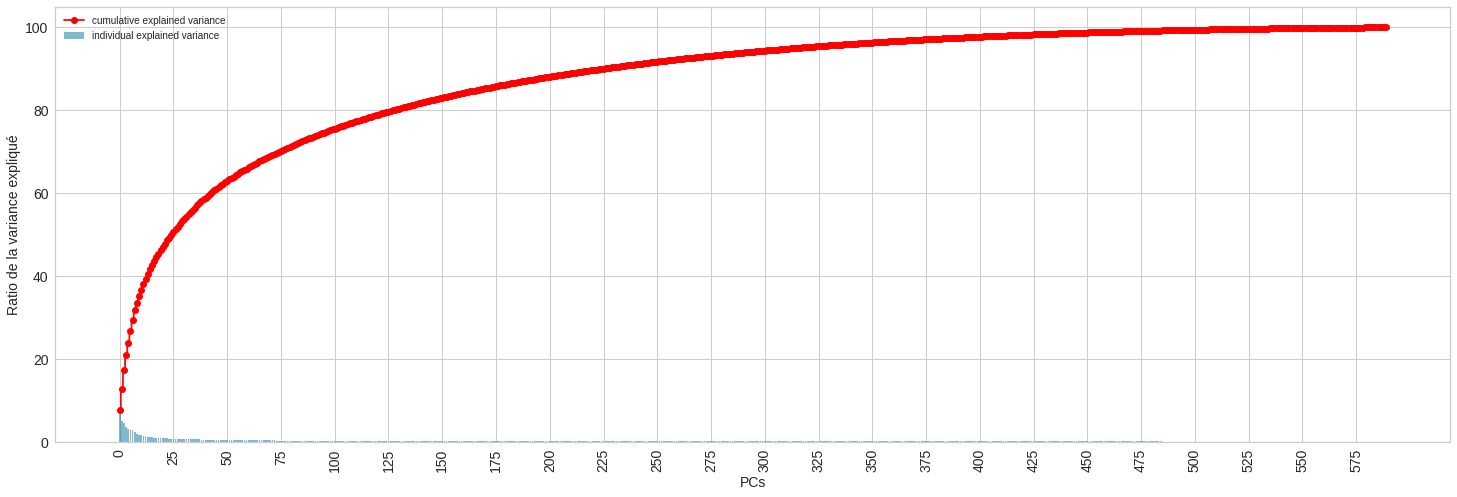

In [10]:
figure_name =Path(str(dir_fig) +'/' + str('PCA_image.jpeg'))
figure_name1 =Path(str("/home/yonss/AndroidStudioProjects/P6_Presentation/Images") +'/' + str('PCA_image.jpeg'))

var_explaned=im_features.shape[1]
[X_pca,pcamodel] = pca_dim_reduction(im_features,var_explaned,figure_name,figure_name1) 
print(np.cumsum(pcamodel.explained_variance_ratio_)[315:])

In [11]:
def pca_red_dim(model_res,var_explained):
    pca = PCA(var_explained)  
    df_PCA = pca.fit_transform(model_res)
    num_pc = len(pca.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))] 
    X_pca   = pca.transform(model_res)
    return pc_list,pca,X_pca

In [13]:
var_explained=315
[X_pca_pc,model_pca,X_pca] = pca_red_dim(X_pca,var_explained)

In [14]:
def fig_pca(X_PCA,ax,df):
    chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
    ax.set_title(chaine)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    sns.scatterplot(
        x=X_PCA[:,0],
        y=X_PCA[:,1],
        hue=df['Categories_text'],ax=ax,
        alpha=0.8,
        s=30
    )


In [15]:
tsne = TSNE(n_components=2, init="pca")
X_tsne  = tsne.fit_transform(X_pca)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne['Categories_img'] = data_merged['Categories_text']
df_tsne['L_Categories_img'] = data_merged['L_Categories_text']

In [16]:
def plot_tsne(df,ax,name,figure_name):
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=name, data=df, ax=ax,legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,size=dss-2)

    ax.set_title('TSNE selon les vraies classes', fontweight = 'bold',size=dss-2)
    ax.set_xlabel('tsne1',size=dss-2)
    ax.set_ylabel('tsne2',size=dss-2)
    plt.xticks(fontsize=dss-2)
    plt.yticks(fontsize=dss-2)
    
    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

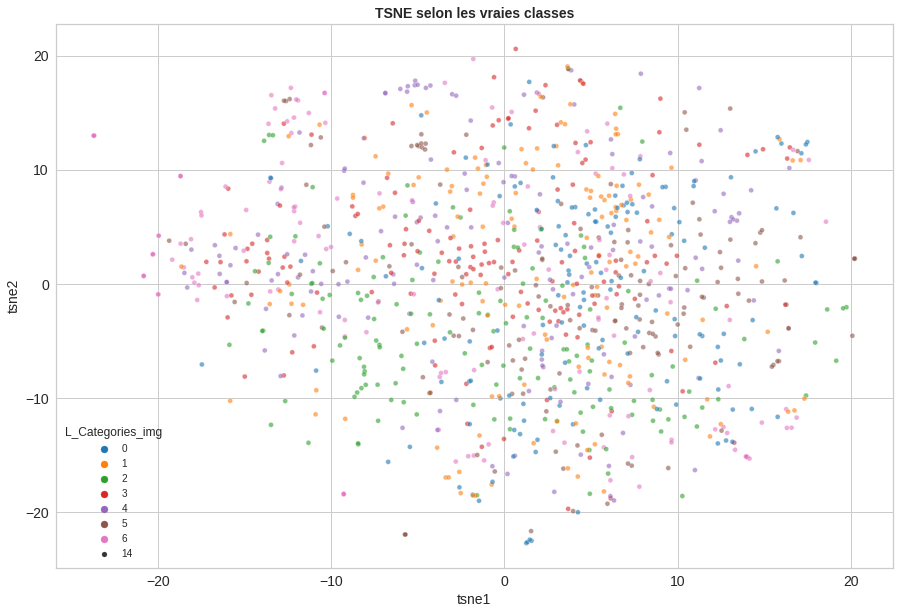

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tsne(df_tsne,ax,'L_Categories_img','TSNE_Image.jpeg')

In [18]:
X=df_tsne
Y=df_tsne['L_Categories_img']

In [19]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
cat_name='Categories_img'
Y_name='L_Categories_img'

Cat_train=x_train[cat_name]
Cat_test =x_test[cat_name]

x_train=x_train.drop([cat_name,Y_name],axis=1)
x_test=x_test.drop([cat_name,Y_name],axis=1)

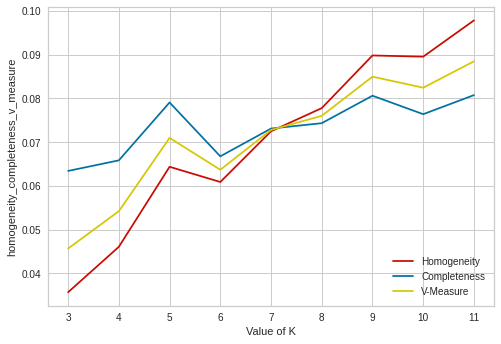

In [20]:
k = range(3,12)
scores = []
 
for n_cluster in k:
    y_pred = KMeans(n_clusters = n_cluster, max_iter=1000, random_state=42).fit_predict(x_train)
    score = metrics.homogeneity_completeness_v_measure(y_train, y_pred)
    scores.append(score)
            
# plotting the scores against the value of k
plt.plot(k, [s[0] for s in scores], 'r', label='Homogeneity')
plt.plot(k, [s[1] for s in scores], 'b', label='Completeness')
plt.plot(k, [s[2] for s in scores], 'y', label='V-Measure')
plt.xlabel('Value of K')
plt.ylabel('homogeneity_completeness_v_measure')
plt.legend(loc=4)
plt.show()

In [21]:
nclusters_cv=7

In [22]:
def stability_measure(nclusters,df):
    inx=0
    inx0=0
    inj=0
    df_stability=pd.DataFrame()
    #
    for knx in range(0,nclusters*3): 
        knx=nclusters
        kmeans_visualizer = KMeans(n_clusters=knx,init='random')
        kmeans_visualizer.fit(df)
        name1='Iteration  '+str(inj)
        df_stability[name1]=kmeans_visualizer.predict(df)
    
        inj0=inj-1
        if inj==0:
            name0=name1
            inj0=inj
        ARI_RFM_KMeans=adjusted_rand_score(df_stability[name1],df_stability[name0])
        print('ARI  '+ str(name1) + ' - ' + str(name0)+'     =  ' , ARI_RFM_KMeans ) 
        name0=name1
        inj=inj+1  
    return df_stability

x_stability = stability_measure(nclusters_cv,x_train)

ARI  Iteration  0 - Iteration  0     =   1.0
ARI  Iteration  1 - Iteration  0     =   0.9639754005862209
ARI  Iteration  2 - Iteration  1     =   0.9196314790736636
ARI  Iteration  3 - Iteration  2     =   0.9427387556763223
ARI  Iteration  4 - Iteration  3     =   0.9343974469415077
ARI  Iteration  5 - Iteration  4     =   0.9698690355971322
ARI  Iteration  6 - Iteration  5     =   0.8353117130279893
ARI  Iteration  7 - Iteration  6     =   0.8735067127048878
ARI  Iteration  8 - Iteration  7     =   0.9410638512913713
ARI  Iteration  9 - Iteration  8     =   0.890881042996596
ARI  Iteration  10 - Iteration  9     =   0.9785714430450279
ARI  Iteration  11 - Iteration  10     =   0.9922101392735468
ARI  Iteration  12 - Iteration  11     =   0.9862088336033322
ARI  Iteration  13 - Iteration  12     =   0.9785714430450279
ARI  Iteration  14 - Iteration  13     =   0.9974336833821881
ARI  Iteration  15 - Iteration  14     =   0.9349014237096229
ARI  Iteration  16 - Iteration  15     =   0.

In [23]:
def final_KMeans_model(X,X_test,nclusters,nstate):
    kmeans_visualizer = KMeans(n_clusters=nclusters,random_state=nstate)
    kmeans_visualizer.fit(X)
    name='Cluster = '+str(nclusters)
    X[name]=kmeans_visualizer.labels_
    # prédire les clusters sur l'ensemble de test
    X_test[name] = kmeans_visualizer.predict(X_test)
    return X,X_test,name ,kmeans_visualizer


[x_train,x_test,namecluster,kmeans_visualizer] = final_KMeans_model(x_train,x_test,nclusters_cv,rstate)

In [24]:
def plot_tsne(df,ax,classe,categor):
    dss=22
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=classe, data=df, ax=ax,legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    ax.set_title('TSNE selon les vraies classes  '+categor, fontweight = 'bold')
    ax.set_xlabel('tsne1',size=dss-2)
    ax.set_ylabel('tsne2',size=dss-2)
    
    ax.tick_params(axis='both', labelsize=20)

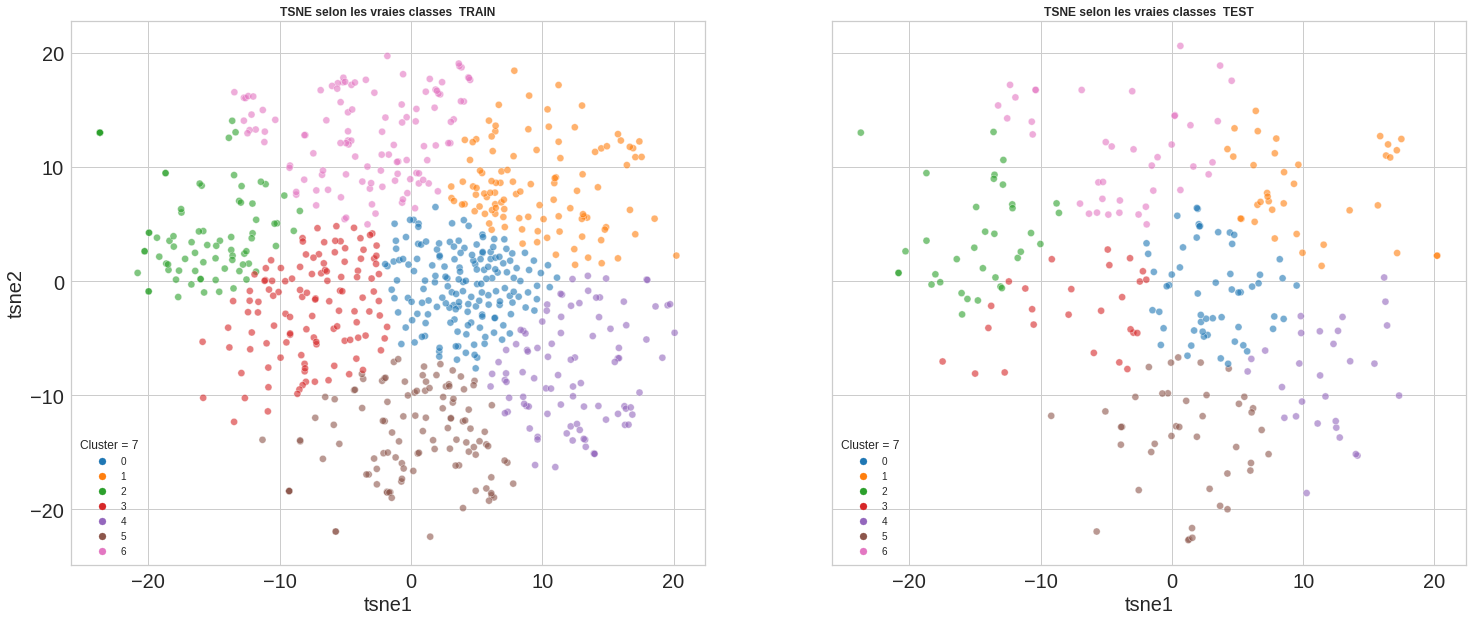

In [25]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10),sharey=True)
plot_tsne(x_train,ax1,namecluster,'TRAIN')
plot_tsne(x_test,ax2,namecluster,'TEST')


plt.savefig('TSNE_2D_image.jpeg',format='jpeg',dpi=100,bbox_inches='tight')

!cp "TSNE_2D_image.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "TSNE_2D_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6

In [26]:
x_train[cat_name]=Cat_train
x_test[cat_name]=Cat_test

x_train[Y_name]=y_train
x_test[Y_name]=y_test

In [27]:
ARI_CAT_KMeans=adjusted_rand_score(x_train[Y_name],x_train[namecluster])

accuracy = accuracy_score(x_train[Y_name],x_train[namecluster])
precision= precision_score(x_train[Y_name],x_train[namecluster], average='weighted')

algo_Performance={"Jeu de données": "Train",'ARI':ARI_CAT_KMeans,'accuracy':accuracy ,'precision':precision}
PerformanceK = pd.DataFrame( algo_Performance,
        index=[0],
    )
ARI_CAT_KMeans=adjusted_rand_score(x_test[Y_name],x_test[namecluster])

accuracy = accuracy_score(x_test[Y_name],x_test[namecluster])
precision= precision_score(x_test[Y_name],x_test[namecluster], average='weighted')

algo_Performance={"Jeu de données": "Test ",'ARI':ARI_CAT_KMeans,'accuracy':accuracy ,'precision':precision}
PerformanceT = pd.DataFrame( algo_Performance,
        index=[1],)
    
df_score=PerformanceK.append(PerformanceT, ignore_index=True)
df_score

,Jeu de données,ARI,accuracy,precision
0,Train,0.04,0.14,0.13
1,Test,0.03,0.14,0.15


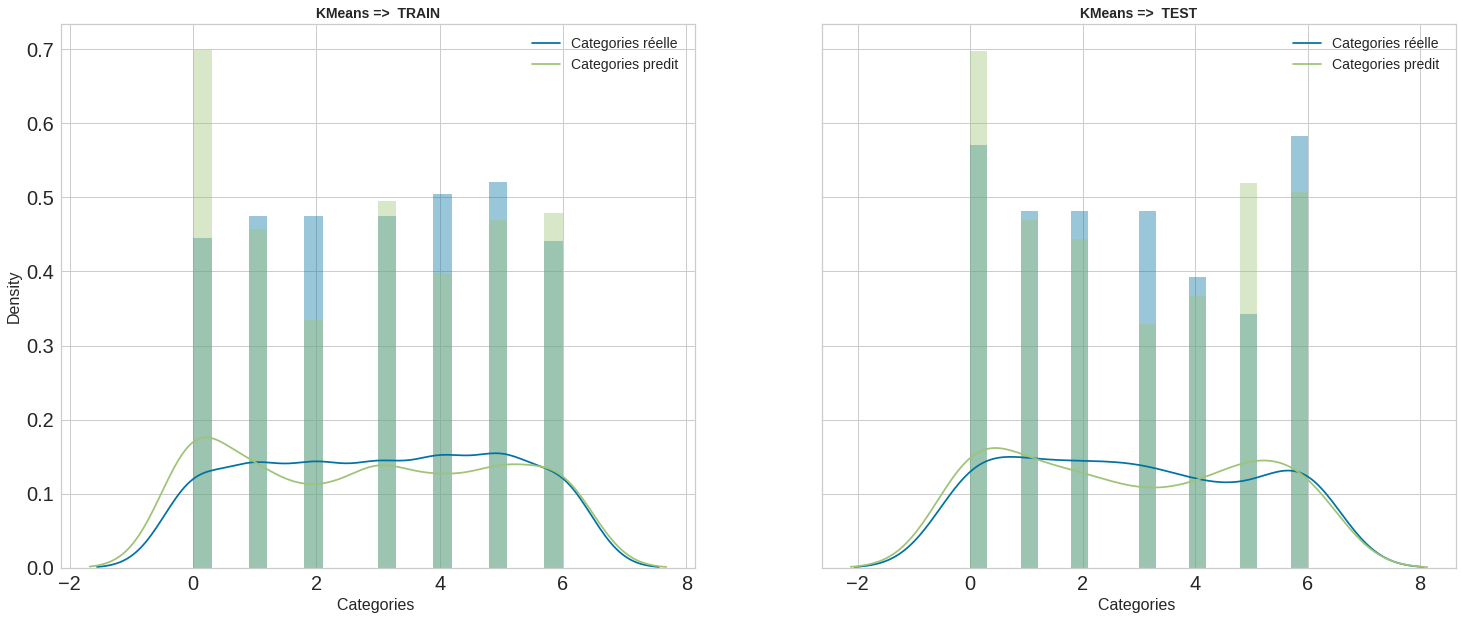

In [28]:
tnx=0
names=["Density_kmeans.jpeg", "KMeans_pie.jpeg"]

def distplot_dense(X,name2,namecluster,nclusters_cv,dss,ax):
    sns.distplot(X[name2], bins=20, rug=False,ax=ax)
    ax.set_title('KMeans => '+ str(nclusters_cv) , weight='bold', size=dss-2)
    sns.distplot(X[namecluster], bins=20, rug=False,ax=ax)
    ax.legend(['Categories réelle', 'Categories predit '], fontsize=dss-2)
    ax.set_ylabel('Density',  size=dss)
    ax.set_xlabel('Categories ',  size=dss)
    ax.tick_params(axis='both', labelsize=20)
    
f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10),sharey=True)
distplot_dense(x_train,Y_name,namecluster,' TRAIN',dss,ax1)
distplot_dense(x_test,Y_name,namecluster,' TEST',dss,ax2)

figure_name=names[tnx]
        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

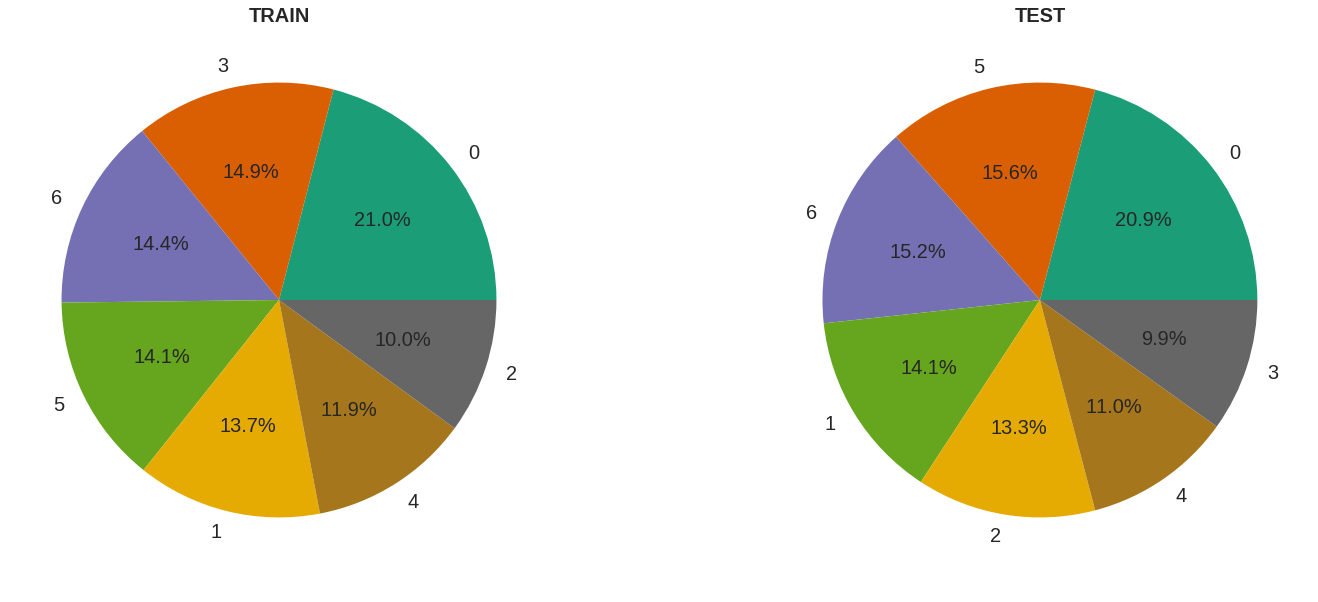

In [29]:
def pie_data(x_train,name2,namecluster,nclusters_cv,dss,ax):

    data_plot_0 = x_train.groupby(namecluster).agg(Clusters =(namecluster,'count'))
    data_plot_0=data_plot_0.sort_values(by='Clusters', ascending=False)
    data_plot_0.plot(kind='pie', x=name2, y='Clusters', title = '', 
    cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax,fontsize=dss).set_title(nclusters_cv,fontsize=dss, weight='bold');

    ax.set_ylabel('', weight='bold', size=dss-2)
    ax.set_xlabel(' ', weight='bold', size=dss)

    
dss=20
f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10),sharey=True)    
pie_data(x_train,Y_name,namecluster,'TRAIN',dss,ax1)  
pie_data(x_test,Y_name,namecluster,'TEST',dss,ax2)
        
        
        
        
plt.savefig("KMeans_pie_image.jpeg",format='jpeg',dpi=100,bbox_inches='tight')

!cp "KMeans_pie_image.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "KMeans_pie_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6

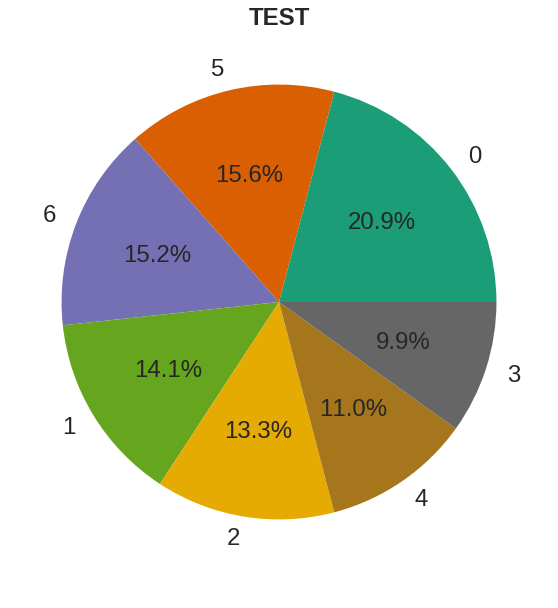

In [30]:
dss=24
f, (ax1) = plt.subplots(1,1, figsize=(25,10),sharey=True)  
pie_data(x_test,Y_name,namecluster,'TEST',dss,ax1)      
              
plt.savefig('KMeans_pie_one_image.jpeg',format='jpeg',dpi=100,bbox_inches='tight')

!cp "KMeans_pie_one_image.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "KMeans_pie_one_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6

In [31]:
cmf_train= confusion_matrix(x_train[Y_name], x_train[namecluster])
cmf_test = confusion_matrix(x_test[Y_name], x_test[namecluster])

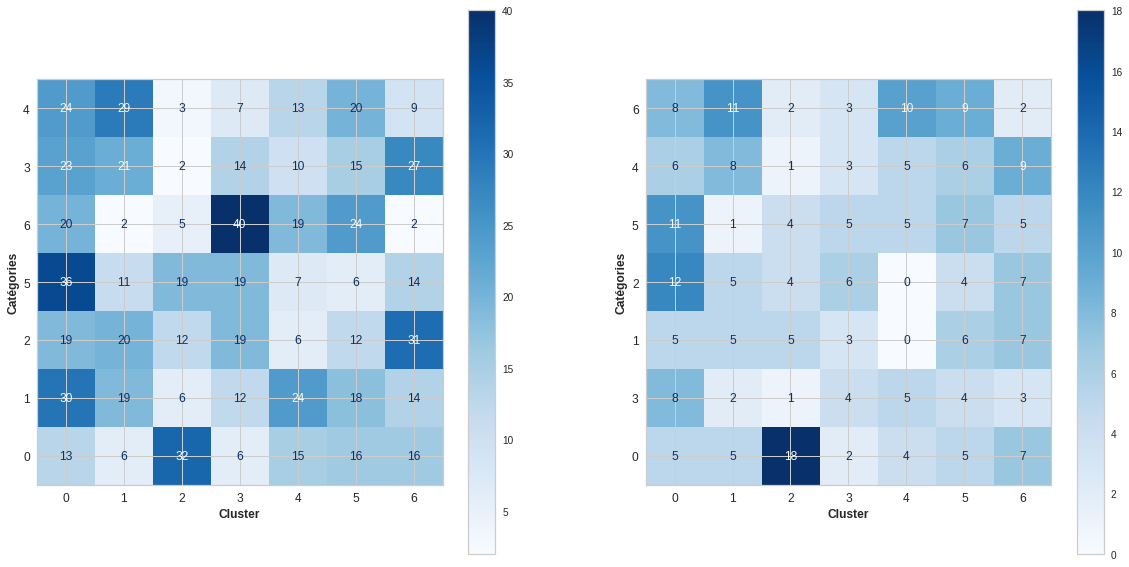

In [32]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
def matrix_conf(cmf,x_train,name2,namecluster,nclusters_cv,dss,ax):
    dss=12
    cm_display = ConfusionMatrixDisplay(cmf).plot(ax=ax,cmap=plt.cm.Blues)
    ax.set_ylabel("Catégories", weight='bold', size=dss)
    ax.set_xlabel('Cluster', weight='bold', size=dss)
    ax.set_yticklabels(x_train[name2].unique(), size=dss)
    
    ax.tick_params(axis='both', labelsize=dss)
    
matrix_conf(cmf_train,x_train,Y_name,namecluster,nclusters_cv,dss,ax1)
matrix_conf(cmf_test,x_test,Y_name,namecluster,nclusters_cv,dss,ax2) 
    